In [1]:
# --- 0. IMPORTS ---
import os
import re
import glob
import random
import xml.etree.ElementTree as ET
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.ops import box_iou, generalized_box_iou
import timm
from transformers import RobertaTokenizer, RobertaModel
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import gc

2025-08-15 15:34:23.055503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755272063.217564      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755272063.274282      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- 1. CONFIGURATION & HYPERPARAMETERS ---
class Config:
    # Data Paths
    DATASET_ROOT = "/kaggle/input"  
    IMAGE_DIR = os.path.join(DATASET_ROOT, "flickr30k", "flickr30k_images")
    ANNOTATIONS_DIR = os.path.join(DATASET_ROOT, "annotations", "Annotations")
    SENTENCES_DIR = os.path.join(DATASET_ROOT, "annotations", "Sentences")

    # Model & Training Hyperparameters
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 32  
    EPOCHS = 5
    LEARNING_RATE = 1e-4
    LR_BACKBONE = 1e-5
    WEIGHT_DECAY = 1e-4
    
    # Vision Model
    # VISION_MODEL_NAME = 'swin_base_patch4_window12_384_in22k'
    VISION_MODEL_NAME = 'vit_small_patch14_reg4_dinov2.lvd142m'
    IMG_SIZE = 518

    # Text Model
    TEXT_MODEL_NAME = 'roberta-base'
    MAX_TEXT_LEN = 40

    # Transformer
    HIDDEN_DIM = 256
    NUM_QUERIES = 10 # Number of potential objects to predict

    # Loss weights
    BBOX_LOSS_COEF = 5
    GIOU_LOSS_COEF = 2
    EOS_COEF = 0.1 # Weight for 'no object' class

    # Run settings
    NUM_SAMPLES_TO_USE = 50000  # Set to None to use all data
    TRAIN_SPLIT = 0.9
    NUM_WORKERS = 2
    MODEL_SAVE_PATH = "vl_gtr_best_model.pth"

print(f"Using device: {Config.DEVICE}")

Using device: cuda


In [3]:
# --- 2. UTILITY FUNCTIONS ---
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [(x0 + x1) / 2, (y0 + y1) / 2,
         (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)

# --- 3. DATA PARSING ---
def parse_flickr_entities(annotations_dir, sentences_dir, num_samples):
    """Parses the Flickr30k Entities dataset to link phrases with their bounding boxes."""
    print("Parsing Flickr30k Entities dataset...")
    all_samples = []
    sentence_files = glob.glob(os.path.join(sentences_dir, '*.txt'))

    for sent_file_path in tqdm(sentence_files, desc="Parsing Files"):
        img_name = os.path.basename(sent_file_path).replace('.txt', '.jpg')
        xml_path = os.path.join(annotations_dir, img_name.replace('.jpg', '.xml'))

        if not os.path.exists(xml_path):
            continue

        tree = ET.parse(xml_path)
        root = tree.getroot()
        id_to_bbox = {}
        for obj in root.findall('object'):
            entity_id = obj.find('name').text
            box = obj.find('bndbox')
            if box is not None:
                bbox = [
                    int(box.find('xmin').text), int(box.find('ymin').text),
                    int(box.find('xmax').text), int(box.find('ymax').text)
                ]
                if entity_id not in id_to_bbox:
                    id_to_bbox[entity_id] = []
                id_to_bbox[entity_id].append(bbox)

        with open(sent_file_path, 'r', encoding='utf-8', errors='ignore') as f:
            for sentence in f:
                entities = re.findall(r'\[/EN#(\d+)/[^ ]+ (.+?)\]', sentence)
                for entity_id, phrase in entities:
                    if entity_id in id_to_bbox:
                        # For each bounding box associated with the entity, create a sample
                        for box in id_to_bbox[entity_id]:
                            all_samples.append({
                                'image_path': os.path.join(Config.IMAGE_DIR, img_name),
                                'phrase': phrase.strip().lower(),
                                'bbox': box
                            })

    random.shuffle(all_samples)
    
    if num_samples:
        print(f"Found {len(all_samples)} total phrase-bbox pairs. Using {num_samples} for this run.")
        return all_samples[:num_samples]
    
    print(f"Found and using {len(all_samples)} total phrase-bbox pairs.")
    return all_samples

In [4]:
# --- 4. PYTORCH DATASET ---
class FlickrGroundingDataset(Dataset):
    def __init__(self, samples, tokenizer, transform):
        self.samples = samples
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image_path = sample['image_path']
        phrase = sample['phrase']
        bbox = torch.tensor(sample['bbox'], dtype=torch.float32)

        try:
            image = Image.open(image_path).convert("RGB")
            original_w, original_h = image.size
        except (IOError, FileNotFoundError):
            print(f"Warning: Could not open {image_path}. Skipping.")
            return self.__getitem__((idx + 1) % len(self))

        # Normalize bounding box to [0, 1] in (x1, y1, x2, y2) format
        bbox[0] /= original_w
        bbox[2] /= original_w
        bbox[1] /= original_h
        bbox[3] /= original_h
        
        # Convert to (cx, cy, w, h) for model consistency
        bbox = box_xyxy_to_cxcywh(bbox)

        processed_image = self.transform(image)
        
        tokenized_text = self.tokenizer(
            phrase, padding='max_length', max_length=Config.MAX_TEXT_LEN,
            truncation=True, return_tensors="pt"
        )
        
        target = {
            'boxes': bbox.unsqueeze(0), # Model expects a batch of boxes
            'labels': torch.tensor([1], dtype=torch.long) # 1 for 'object', 0 for 'no object'
        }
        
        return {
            'image': processed_image,
            'input_ids': tokenized_text['input_ids'].squeeze(0),
            'attention_mask': tokenized_text['attention_mask'].squeeze(0),
            'target': target
        }

def custom_collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return {
        'image': torch.stack([item['image'] for item in batch]),
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'target': [item['target'] for item in batch]  # Keeps targets as a list of dicts
    }

In [5]:
# --- 5. VL-GTR MODEL ARCHITECTURE ---
class VL_GTR(nn.Module):
    def __init__(self, vision_model_name, text_model_name, hidden_dim, num_queries):
        super().__init__()
        self.num_queries = num_queries
        
        # Vision Backbone
        self.vision_backbone = timm.create_model(vision_model_name, pretrained=True, features_only=True)
        self.vision_channels = self.vision_backbone.feature_info.channels()[-1]
        
        # Text Backbone
        self.text_model = RobertaModel.from_pretrained(text_model_name)
        text_feat_dim = self.text_model.config.hidden_size

        # Projection layers
        self.input_proj = nn.Conv2d(self.vision_channels, hidden_dim, kernel_size=1)
        self.text_proj = nn.Linear(text_feat_dim, hidden_dim)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=hidden_dim, nhead=8, num_encoder_layers=6,
            num_decoder_layers=6, dim_feedforward=2048, dropout=0.1
        )
        
        # Prediction Heads
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.bbox_head = nn.Linear(hidden_dim, 4) 
        self.class_head = nn.Linear(hidden_dim, 2) # 0: no-object, 1: object

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, 197, hidden_dim))


    def forward(self, images, input_ids, attention_mask):
        # Image features
        # First, permute the tensor from (B, H, W, C) to (B, C, H, W)
        # vision_features = self.vision_backbone(images)[-1].permute(0, 3, 1, 2)
        vision_features = self.vision_backbone(images)[-1]
        
        # THEN, apply the convolution to the correctly shaped tensor
        proj_vision_features = self.input_proj(vision_features)
        
        B, C, H, W = proj_vision_features.shape
        flat_vision_features = proj_vision_features.flatten(2).permute(2, 0, 1) # (H*W, B, C)
        
        # Assuming ViT-like backbone output for positional encoding
        # This is a simplification; a more robust solution would use dynamic positional encodings
        pos_embed = self.positional_encoding[:, :flat_vision_features.shape[0], :].permute(1,0,2).repeat(1,B,1)

        # Text features
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_cls_embedding = text_output.last_hidden_state[:, 0, :]
        proj_text = self.text_proj(text_cls_embedding).unsqueeze(0) # (1, B, C)
        
        # Transformer Inputs
        query_embed = self.query_embed.weight.unsqueeze(1).repeat(1, B, 1) # (num_queries, B, C)
        
        # For this model, we'll concatenate text to the vision features as memory
        memory = torch.cat([proj_text, flat_vision_features], dim=0)
        memory_pos = torch.cat([torch.zeros_like(proj_text), pos_embed], dim=0)
        
        # forward pass
        hs = self.transformer.decoder(query_embed, memory, memory_key_padding_mask=None)
        
        hs = hs.permute(1, 0, 2)
        
        # Predictions
        output_class = self.class_head(hs)
        output_coord = self.bbox_head(hs).sigmoid()
        
        return {'pred_logits': output_class, 'pred_boxes': output_coord}

In [6]:
# --- 6. HUNGARIAN MATCHER & LOSS FUNCTION ---
class HungarianMatcher(nn.Module):
    def __init__(self, cost_class: float = 1, cost_bbox: float = 1, cost_giou: float = 1):
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        bs, num_queries = outputs["pred_logits"].shape[:2]

        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)
        out_bbox = outputs["pred_boxes"].flatten(0, 1)

        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        cost_class = -out_prob[:, tgt_ids]

        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox),
                                          box_cxcywh_to_xyxy(tgt_bbox))

        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]


class GroundingLoss(nn.Module):
    def __init__(self, matcher, eos_coef):
        super().__init__()
        self.matcher = matcher
        self.eos_coef = eos_coef
        
        # The 'no object' class weight is set lower
        empty_weight = torch.ones(2)
        empty_weight[0] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices):
        src_logits = outputs['pred_logits']
        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], 0, dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = nn.functional.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight.to(src_logits.device))
        return {'loss_ce': loss_ce}

    def loss_boxes(self, outputs, targets, indices):
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = nn.functional.l1_loss(src_boxes, target_boxes, reduction='none')
        
        loss_giou = 1 - torch.diag(generalized_box_iou(
            box_cxcywh_to_xyxy(src_boxes),
            box_cxcywh_to_xyxy(target_boxes)))
            
        return {'loss_bbox': loss_bbox.sum() / len(target_boxes), 
                'loss_giou': loss_giou.sum() / len(target_boxes)}

    def _get_src_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def forward(self, outputs, targets):
        indices = self.matcher(outputs, targets)
        
        loss_dict = {}
        loss_dict.update(self.loss_labels(outputs, targets, indices))
        loss_dict.update(self.loss_boxes(outputs, targets, indices))
        
        return loss_dict

In [7]:
# --- 7. TRAINING & EVALUATION ---
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", unit="batch")
    
    for batch in progress_bar:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in batch['target']]

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        
        loss_dict = loss_fn(outputs, targets)
        weight_dict = {'loss_ce': 1, 'loss_bbox': Config.BBOX_LOSS_COEF, 'loss_giou': Config.GIOU_LOSS_COEF}
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys())
        
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        progress_bar.set_postfix(loss=f"{losses.item():.4f}")

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_iou = 0
    correct_at_0_5 = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", unit="batch"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in batch['target']]

            outputs = model(images, input_ids, attention_mask)
            
            # Post-processing: get the box with the highest 'object' score
            pred_scores = outputs['pred_logits'].softmax(-1)[:, :, 1] # score for 'object' class
            best_indices = pred_scores.argmax(-1)
            
            pred_boxes = torch.stack([outputs['pred_boxes'][i, best_indices[i], :] for i in range(images.shape[0])])
            gt_boxes = torch.stack([t['boxes'][0] for t in targets])
            
            # Calculate IoU
            iou = box_iou(box_cxcywh_to_xyxy(pred_boxes), box_cxcywh_to_xyxy(gt_boxes))
            
            batch_iou = torch.diag(iou)
            total_iou += batch_iou.sum().item()
            correct_at_0_5 += (batch_iou > 0.5).sum().item()
            total_samples += len(images)
            
    mean_iou = total_iou / total_samples if total_samples > 0 else 0
    accuracy_at_0_5 = correct_at_0_5 / total_samples if total_samples > 0 else 0
    return mean_iou, accuracy_at_0_5

In [8]:
# --- 8. VISUALIZATION ---
def visualize_prediction(model, dataset, device, num_samples=3):
    model.eval()
    print("\n--- Visualizing Predictions ---")
    
    for _ in range(num_samples):
        sample_idx = random.randint(0, len(dataset) - 1)
        data = dataset[sample_idx]
        
        image_tensor = data['image'].unsqueeze(0).to(device)
        input_ids = data['input_ids'].unsqueeze(0).to(device)
        attention_mask = data['attention_mask'].unsqueeze(0).to(device)
        gt_box_cxcywh = data['target']['boxes'].squeeze(0)
        
        with torch.no_grad():
            output = model(image_tensor, input_ids, attention_mask)
        
        # Get best predicted box
        scores = output['pred_logits'].softmax(-1)[0, :, 1]
        best_idx = scores.argmax()
        pred_box_cxcywh = output['pred_boxes'][0, best_idx, :].cpu()

        # Denormalize image for display
        img = image_tensor.squeeze(0).cpu().permute(1, 2, 0)
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        img = T.ToPILImage()(img.permute(2, 0, 1))
        
        # Denormalize boxes
        W, H = img.size
        gt_box_xyxy = box_cxcywh_to_xyxy(gt_box_cxcywh) * torch.tensor([W, H, W, H])
        pred_box_xyxy = box_cxcywh_to_xyxy(pred_box_cxcywh) * torch.tensor([W, H, W, H])
        
        # Draw boxes
        draw = ImageDraw.Draw(img)
        draw.rectangle(gt_box_xyxy.tolist(), outline="lime", width=3)
        draw.rectangle(pred_box_xyxy.tolist(), outline="red", width=3)
        
        # Add text
        phrase = dataset.tokenizer.decode(data['input_ids'], skip_special_tokens=True)
        try:
            font = ImageFont.truetype("arial.ttf", 15)
        except IOError:
            font = ImageFont.load_default()
        draw.text((5, 5), f"Phrase: {phrase}", fill="white", font=font)
        draw.text((5, 25), "GT (Green), Pred (Red)", fill="white", font=font)

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [9]:
gc.collect()
torch.cuda.empty_cache()

In [10]:
all_samples = parse_flickr_entities(Config.ANNOTATIONS_DIR, Config.SENTENCES_DIR, Config.NUM_SAMPLES_TO_USE)

Parsing Flickr30k Entities dataset...


Parsing Files: 100%|██████████| 31783/31783 [04:36<00:00, 114.76it/s]


Found 655287 total phrase-bbox pairs. Using 50000 for this run.


In [11]:
# 1. Data Preparation
print("Preparing data...")
tokenizer = RobertaTokenizer.from_pretrained(Config.TEXT_MODEL_NAME)
image_transform = T.Compose([
    T.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

split_idx = int(len(all_samples) * Config.TRAIN_SPLIT)
train_samples = all_samples[:split_idx]
val_samples = all_samples[split_idx:]

train_dataset = FlickrGroundingDataset(train_samples, tokenizer, image_transform)
val_dataset = FlickrGroundingDataset(val_samples, tokenizer, image_transform)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, collate_fn=custom_collate_fn)

Preparing data...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [12]:
# 2. Model, Loss, Optimizer
print("Initializing model...")
model = VL_GTR(
    vision_model_name=Config.VISION_MODEL_NAME,
    text_model_name=Config.TEXT_MODEL_NAME,
    hidden_dim=Config.HIDDEN_DIM,
    num_queries=Config.NUM_QUERIES
).to(Config.DEVICE)

matcher = HungarianMatcher(cost_class=1, cost_bbox=Config.BBOX_LOSS_COEF, cost_giou=Config.GIOU_LOSS_COEF)
loss_fn = GroundingLoss(matcher=matcher, eos_coef=Config.EOS_COEF)

# Separate parameters for backbone and transformer
optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5)

Initializing model...


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [13]:
# --- FREEZE THE BACKBONES ---
print("Freezing vision and text backbones...")
for name, param in model.named_parameters():
    if name.startswith("vision_backbone") or name.startswith("text_model"):
        param.requires_grad = False
print("Backbones frozen.")
# Unfreeze the custom-added parts of your model (transformer head, etc.)
for name, param in model.named_parameters():
    if not name.startswith("vision_backbone") and not name.startswith("text_model"):
        param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params:,}")
print(f"Total Parameters: {total_trainable_params:,}")

Freezing vision and text backbones...
Backbones frozen.
Total Parameters: 164,416,134
Total Parameters: 17,713,926


In [14]:
# Add this line to see what's inside the wrapper
print(dir(model.vision_backbone))

['T_destination', '__annotations__', '__call__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_member

In [15]:
print("Unfreezing the top layer of the vision backbone...")
# First, ensure everything is frozen
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last layer block of the vision model
for param in model.vision_backbone.parameters():
    param.requires_grad = True

# Create an optimizer that only trains these un-frozen parameters
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params, lr=1e-5) # Use a low learning rate!

# --- (Optional) VERIFY PARAMETER COUNT ---
total_params = sum(p.numel() for p in model.parameters())
trainable_params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters after selective unfreezing: {trainable_params_count:,}")

Unfreezing the top layer of the vision backbone...
Total parameters: 164,416,134
Trainable parameters after selective unfreezing: 22,056,576


In [16]:
# 3. Training Loop
print("Starting training process...")
best_acc = 0.0
for epoch in range(Config.EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{Config.EPOCHS} ---")
    avg_train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, Config.DEVICE)
    mean_iou, acc_at_05 = evaluate(model, val_loader, Config.DEVICE)
    
    lr_scheduler.step()
    
    print(f"Epoch {epoch+1} Summary | Avg Train Loss: {avg_train_loss:.4f} | Avg Val IoU: {mean_iou:.4f} | Acc@0.5: {acc_at_05:.4f}")

    if acc_at_05 > best_acc:
        best_acc = acc_at_05
        torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
        print(f"New best model saved with Acc@0.5: {best_acc:.4f}")

print(f"\nTraining complete. Best validation Acc@0.5: {best_acc:.4f}")

Starting training process...

--- Epoch 1/5 ---


Evaluating: 100%|██████████| 157/157 [01:49<00:00,  1.43batch/s]


Epoch 1 Summary | Avg Train Loss: 5.0984 | Avg Val IoU: 0.1728 | Acc@0.5: 0.0976
New best model saved with Acc@0.5: 0.0976

--- Epoch 2/5 ---


Training:  13%|█▎        | 185/1407 [07:47<51:30,  2.53s/batch, loss=4.9148]


KeyboardInterrupt: 

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
for epoch in range(Config.EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{Config.EPOCHS} ---")
    avg_train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, Config.DEVICE)
    mean_iou, acc_at_05 = evaluate(model, val_loader, Config.DEVICE)
    
    lr_scheduler.step()
    
    print(f"Epoch {epoch+1} Summary | Avg Train Loss: {avg_train_loss:.4f} | Avg Val IoU: {mean_iou:.4f} | Acc@0.5: {acc_at_05:.4f}")

    if acc_at_05 > best_acc:
        best_acc = acc_at_05
        torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
        print(f"New best model saved with Acc@0.5: {best_acc:.4f}")

Loading best model for visualization...

--- Visualizing Predictions ---


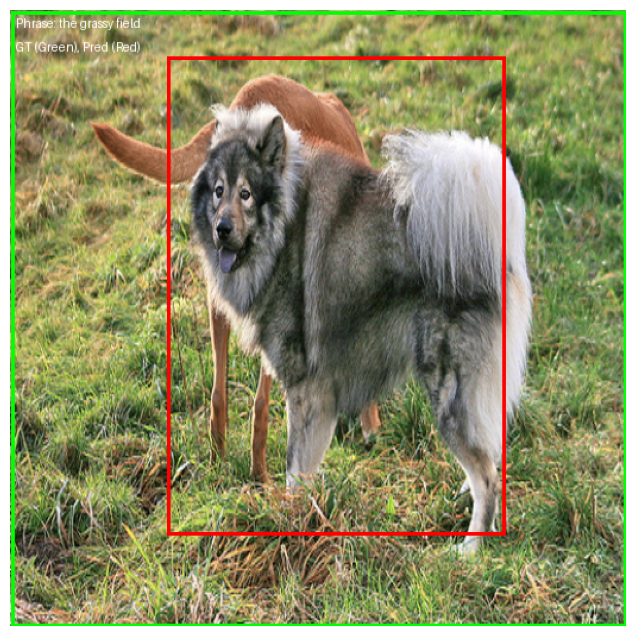

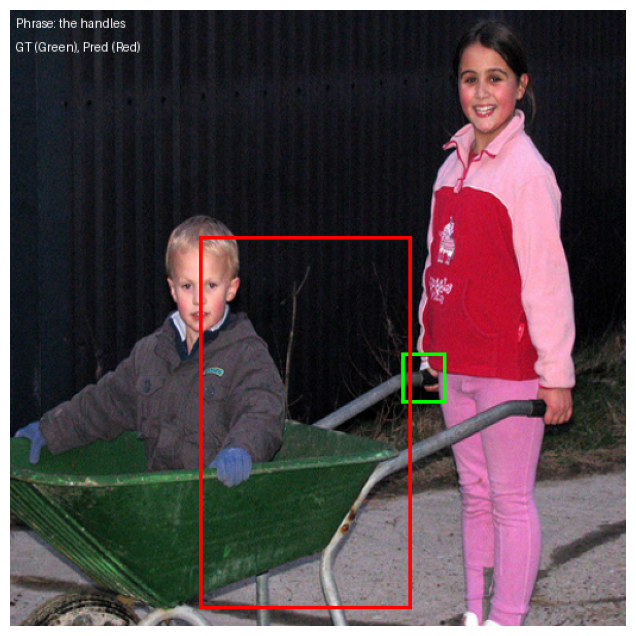

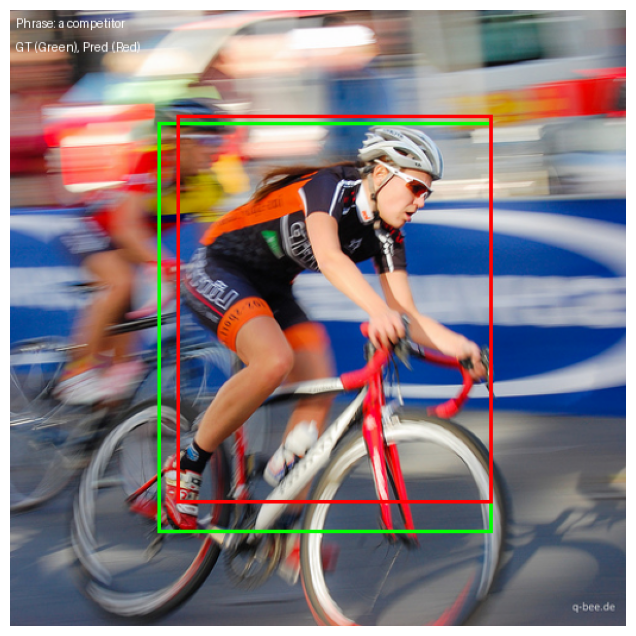

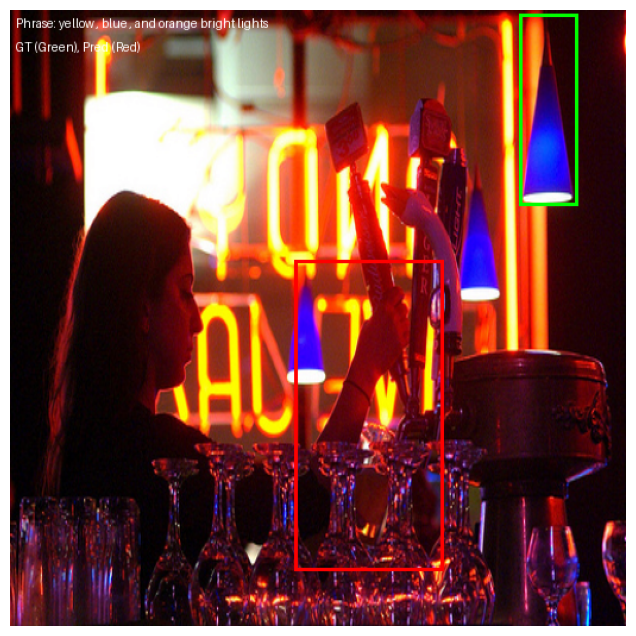

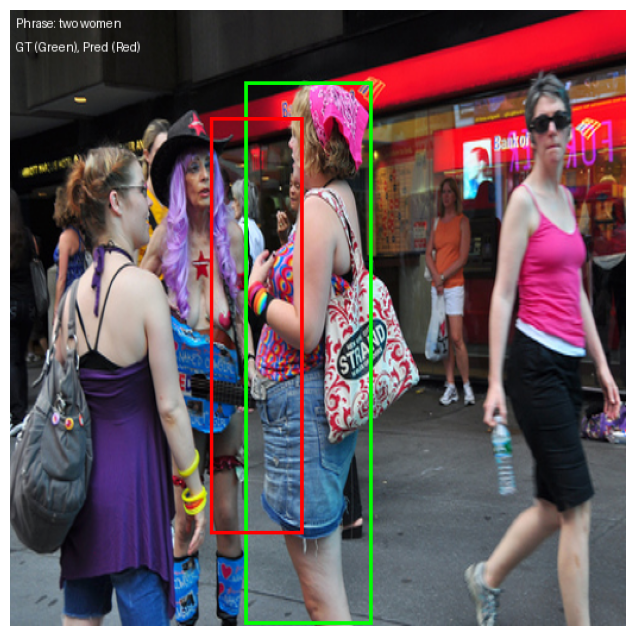

In [17]:
 # 4. Final Visualization
print("Loading best model for visualization...")
model.load_state_dict(torch.load(Config.MODEL_SAVE_PATH, map_location=Config.DEVICE))
visualize_prediction(model, val_dataset, Config.DEVICE, num_samples=5)

In [ ]:
import pickle
import torch

# Assuming 'model' is your trained PyTorch model object

# --- Saving with pickle (NOT RECOMMENDED) ---
with open('model.pkl', 'wb') as f:
    # You would still save the state_dict for flexibility
    pickle.dump(model.state_dict(), f)